## Flight Cancellation



In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import calendar
import datetime
from scipy.stats import pearsonr 
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

## Loading the dataset

In [2]:
os.chdir("D:/Digitas/")
df = pd.read_csv('FlightDelays_Data_3.0.csv')

## Data Pre-processing

1. Null Value treatment
2. Checking for erroneous data (if any)

### Null Value treatment

#### Total Number of Records

In [3]:
len(df)

6000

#### Checking data types and null types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
Canceled            5999 non-null float64
Month               6000 non-null int64
DepartureTime       6000 non-null int64
UniqueCarrier       6000 non-null object
SchedElapsedTime    5998 non-null float64
ArrDelay            5999 non-null float64
DepDelay            6000 non-null int64
Distance            5999 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 375.1+ KB


#### Making a copy of the data for all the further operations

In [5]:
df_new = df.copy()

#### Null value treatment : Data imputation with the mean values of its respective columns 

In [6]:
# Data imputation with the mean value

df_new['SchedElapsedTime'].fillna(df_new['SchedElapsedTime'].mean(), inplace = True)
df_new['ArrDelay'].fillna(df_new['ArrDelay'].mean(), inplace = True)
df_new['Distance'].fillna(df_new['Distance'].mean(), inplace = True)

#### Null value treatment : Removing null values in the target variable 

In [7]:
df_new = df_new.dropna(how='any',axis=0) 
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 8 columns):
Canceled            5999 non-null float64
Month               5999 non-null int64
DepartureTime       5999 non-null int64
UniqueCarrier       5999 non-null object
SchedElapsedTime    5999 non-null float64
ArrDelay            5999 non-null float64
DepDelay            5999 non-null int64
Distance            5999 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 421.8+ KB


### Check for erroneous data

##### Checking the correctness of data

In [8]:
df_new[df_new['Distance'] < 0]

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
134,1.0,3,515,DL,105.0,0.0,0,-439.0


In [9]:
df_new[df_new['SchedElapsedTime'] < 0]

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
67,1.0,5,1540,UA,-127.0,0.0,0,612.0


In [10]:
outlier_dist_idx = df_new[df_new['Distance'] < 0].index[0]
outlier_schElap_idx = df_new[df_new['SchedElapsedTime'] < 0].index[0]

df_new = df_new.drop([outlier_dist_idx], axis = 0)
df_new = df_new.drop([outlier_schElap_idx], axis = 0)

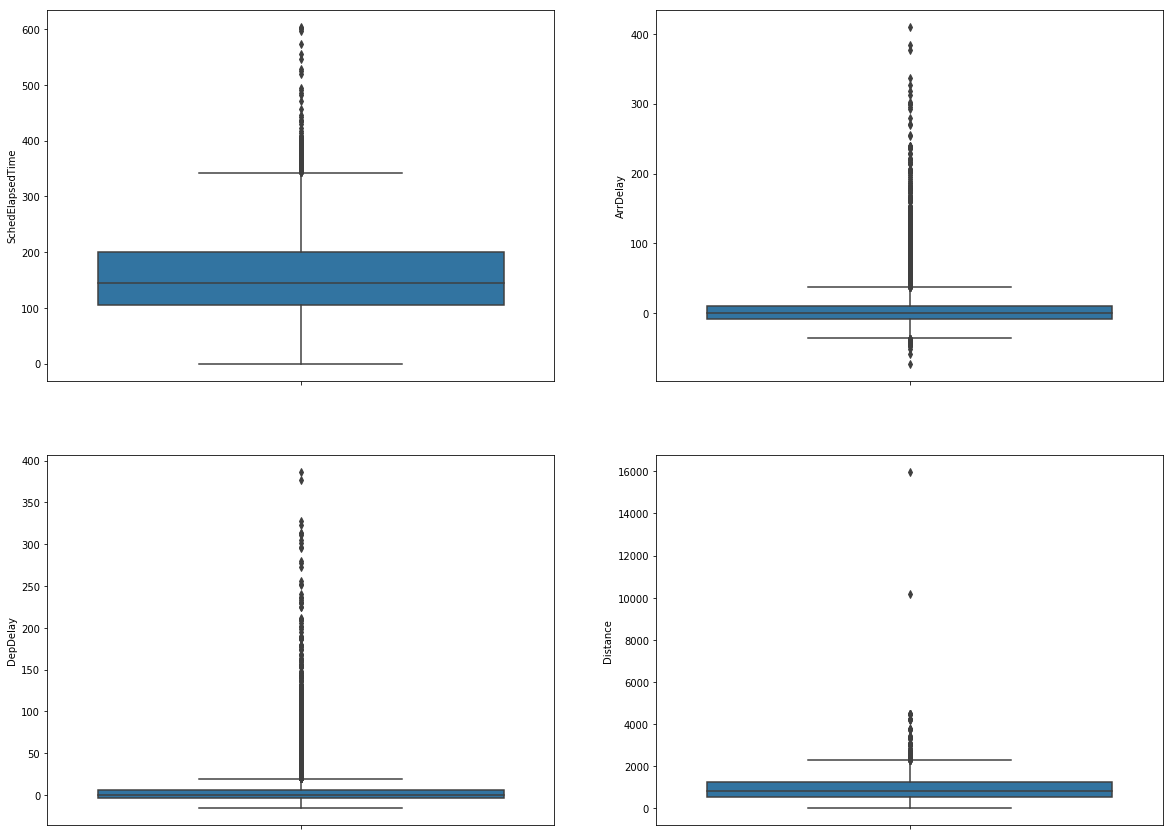

In [11]:
f, axes = plt.subplots(2,2,figsize=(20,15))
i = 0

sns.boxplot(y = 'SchedElapsedTime', data=df_new, orient="v", ax = axes[0][0])
sns.boxplot(y = 'ArrDelay', data=df_new, orient="v", ax = axes[0][1])
sns.boxplot(y = 'DepDelay', data=df_new, orient="v", ax = axes[1][0])
sns.boxplot(y = 'Distance', data=df_new, orient="v", ax = axes[1][1])


None of the outliuer values look like an anamoly. Hence I am keeping them for time being

#### Converting the column into a categorical variable with 1's and 0's

In [12]:
# Convert target variable into int
df_new['Canceled'] = df_new['Canceled'].astype('int32')
df_new['Canceled'] = pd.Categorical(df_new['Canceled'])

df_new.dtypes

Canceled            category
Month                  int64
DepartureTime          int64
UniqueCarrier         object
SchedElapsedTime     float64
ArrDelay             float64
DepDelay               int64
Distance             float64
dtype: object

### Exploratory Data Analysis

#### Checking the distribution of Target variable

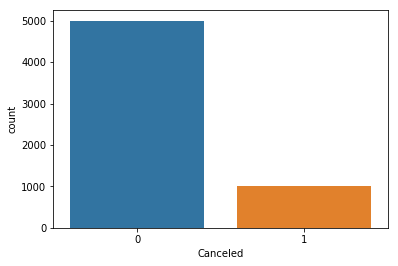

In [13]:
ax = sns.countplot(x="Canceled", data=df_new)

We can see that the target variable is not balanced. There are more occurances of cancellation.

We should now analyze all the predictors individually to see their distribution
Also we should do a bivariate analysis between the predictors and the target. Since some of them are categorical and some are numerical, we need to have a test crieteria. I will be using chi-square statistic for categorical and Anova for numericaol variables to see if the variable is dependent on the target or not

##### Defining function for CHI SQUARE statistic

In [14]:
# contingency table
def chi_sq(data,a,b):
    df = pd.crosstab(data[a], data[b])
    contingency_input = df.as_matrix()

    stat, p, dof, expected = chi2_contingency(contingency_input)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    
    # using p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')


##### Defining function for ANOVA statistic

In [15]:
def anova_stat(df, a, b):
    F, p = stats.f_oneway(df[df[b] == 1][a],
                      df[df[b] == 0][a])
    
    print("F value = %.9f"%F)
    print("p value = %.9f"%p)
    if p < 0.05:
        print("%s is significant."%a)
    else:
        print("%s is not significant."%a)

## Analyzing each column

### Month 

In [16]:
type(df_new['Month'][0])

numpy.int64

In [17]:
df_new['Month'] = df_new['Month'].apply(lambda x: calendar.month_abbr[x])

Let's check the distribution of cancelled flights across all the months

C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


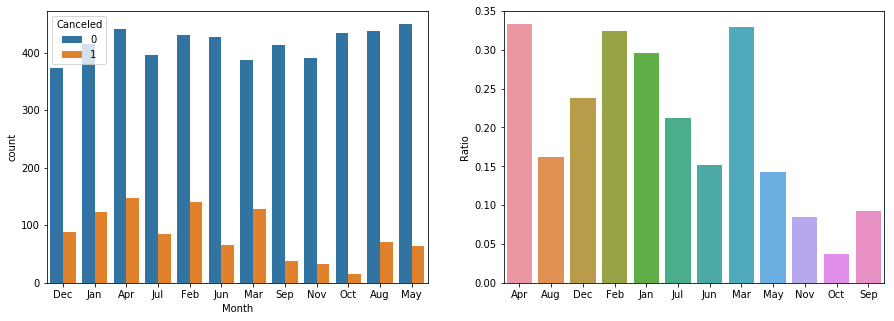

In [18]:
# Month for most of the Canceled flights - October
df_month_new = df_new.groupby('Month').Canceled.agg({
    '0': lambda x: (x==0).sum(),
    '1': lambda x: (x==1).sum()    
})
df_month_new['Ratio'] = df_month_new['1']/df_month_new['0']

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax1 = sns.countplot(x="Month", hue="Canceled", data=df_new, ax = ax[0])
ax2 = sns.barplot(x=df_month_new.index.values, y="Ratio", data=df_month_new, ax = ax[1])

In [19]:
# Correlation with Target Variable 'Canceled'
chi_sq(df_new,'Month','Canceled')

probability=0.950, critical=19.675, stat=212.252
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


#### This shows that cancelation is dependant on 'month'

Since the number of levels in this variable is 12, let's try to reduce it in a logical manner. This is being done to reduce the sparsity of matrix in future(since most of the algorithms require one-hot encoding for the categorical variables)

Aggregating months into different seasons

In [21]:
df_new['Month_Season'] = df_new['Month'].apply(lambda x: 'Winter' if x in ('Jan', 'Feb', 'Mar') else ('Spring' if x in ('Apr', 'May', 'Jun') else ('Summer' if x in ('Jul', 'Aug', 'Sept') else 'Fall')))

C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


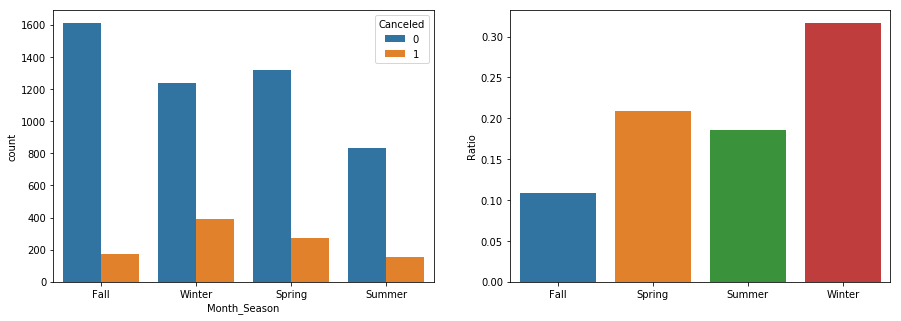

In [22]:
df_month_new = df_new.groupby('Month_Season').Canceled.agg({
    '0': lambda x: (x==0).sum(),
    '1': lambda x: (x==1).sum()    
})
df_month_new['Ratio'] = df_month_new['1']/df_month_new['0']

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax1 = sns.countplot(x="Month_Season", hue="Canceled", data=df_new, ax = ax[0])
ax2 = sns.barplot(x=df_month_new.index.values, y="Ratio", data=df_month_new, ax = ax[1])

Let's check the importance of new variable wrt the target

In [23]:
chi_sq(df_new,'Month_Season','Canceled')

probability=0.950, critical=7.815, stat=124.887
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


The new formed variable is still very important. Which means the target is dependant on this.


*********** Included in the model ****************

In [24]:
selected_cols = []
selected_cols.append('Month_Season')

### DepartureTime 
The time is in military timing so in order to convert it to a feature we can create a new column to mark the timing bucket corresponding to the departure time hence making it into a categorical variable named as 'DeptTimeSession'

In [72]:
for i, val in df_new.iterrows():
    if (len(str(val['DepartureTime']))) == 3:
        converted_time = datetime.time(hour=int(str(val['DepartureTime'])[0:1]), minute=int(str(val['DepartureTime'])[1:3]))
        df_new.iloc[i, df_new.columns.get_loc('DepartureTime')] = datetime.datetime.combine(datetime.datetime.today(), converted_time)
    elif (len(str(val['DepartureTime']))) == 4:
        converted_time = datetime.time(hour=int(str(val['DepartureTime'])[0:2]), minute=int(str(val['DepartureTime'])[2:4]))
        df_new.iloc[i, df_new.columns.get_loc('DepartureTime')] = datetime.datetime.combine(datetime.datetime.today(), converted_time)
df_new['DepartureTime'] = pd.to_datetime(df_new['DepartureTime'], errors='coerce')

session=pd.cut(df_new.DepartureTime.dt.hour,
               [0,6,12,18,23],
               labels=['Night','Morning','Afternoon','Evening'],
               include_lowest=True)

df_new['DepTimeSession'] = session    

In [ ]:
df_dept_new = df_new.groupby('DepTimeSession').Canceled.agg({
    '0': lambda x: (x==0).sum(),
    '1': lambda x: (x==1).sum()
    })

df_dept_new['Ratio'] = df_dept_new['1']/df_dept_new['0']
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax1 = sns.countplot(x="DepTimeSession", hue="Canceled", data=df_new, ax = ax[0])

ax2 = sns.barplot(x=df_dept_new.index.values, y="Ratio", data=df_dept_new, ax = ax[1])

The visualizations show that there is a slight variation in cancelation across different times of a day. Let's check it statistically

In [ ]:
chi_sq(df_new,'DepTimeSession','Canceled')

The chi-sq statistic says that the target is not dependant on the timings. Also the p-value is greater than 0.05.

******************* Not included in the mode **************************

## UniqueCarrier

In [ ]:
df_uc_new = df_new.groupby('UniqueCarrier').Canceled.agg({
    '0': lambda x: (x==0).sum(),
    '1': lambda x: (x==1).sum()
})

df_uc_new['Ratio'] = df_uc_new['1']/df_uc_new['0']


fig, ax = plt.subplots(1,2,figsize=(15,5))
ax1 = sns.countplot(x="UniqueCarrier", hue="Canceled", data=df_new, ax = ax[0])

ax2 = sns.barplot(x=df_uc_new.index.values, y="Ratio", data=df_uc_new, ax = ax[1])

IT looks like there is a variation in cancelation across airlines. Let's check the chi-square statistic

In [ ]:
chi_sq(df_new,'UniqueCarrier','Canceled')

The chi-sq statistic shows that the target is dependant on this variable.

**************** Included in the model *********************

In [62]:
selected_cols.append('UniqueCarrier')

### SchedElapsedTime

#### Converting Scheduled flight time(in minutes) to military time to be comparable to Departure time.

The time should be propotional to the distance of the rout(excluding some macro factors). Let's check the correlation between scheduled elapsed time and the distance.

In [ ]:
pearsonr(df_new['SchedElapsedTime'], df_new['Distance'])

This shows that scheduled elapsed time is extremely correlated to the distance. Using this information we can take one of these two variables to address a potential multi-collinearity. Let's check the statistical significance of these variables w.r.t the target.

#### SchedElapsedTime with Target Variable

In [ ]:
anova_stat(df_new,'SchedElapsedTime','Canceled')

In [ ]:
anova_stat(df_new,'Distance','Canceled')

In [ ]:
sns.distplot(df_new[df_new['Canceled']==0]['Distance'])

In [26]:
(df_new[df_new['Canceled']==0]['Distance']).mean() , (df_new[df_new['Canceled']==1]['Distance']).mean()

(1013.5513102620524, 881.5753413812122)

We can see that the p-value is smaller for distance. Therefore we can conclude that the target is more dependant on this variable

****************** Included in the model ***********************

In [27]:
selected_cols.append('Distance')

### ArrDelay and DepDelay

Hypothesis - If the fight has arrived late it will depart late by almost the same amount of time. Let's validate this by seeing the correlation between these 2 quantities

In [28]:
pearsonr(df_new['ArrDelay'], df_new['DepDelay'])

(0.8961122517063191, 0.0)

Pearson's correlation validates the hypothesis till a great extent. This will help us in future. We can select just one of these two variables in order to addressa potential multi-collinearity

Let's see the distribution of arrival delay for canceled and not-canceled flights

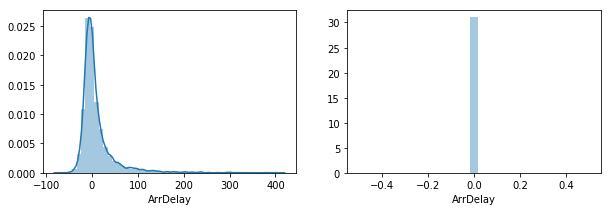

In [71]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
sns.distplot(df_new[df_new['Canceled']==0]['ArrDelay'], ax = ax[0])
sns.distplot(df_new[df_new['Canceled']==1]['ArrDelay'], ax = ax[1])

Average delay in arrival accross different airlines

In [79]:
(df_new[(df_new['Canceled']==0) & (df_new['UniqueCarrier']=='DL')]['ArrDelay']).mean() , (df_new[(df_new['Canceled']==0) & (df_new['UniqueCarrier']=='UA')]['ArrDelay']).mean() , (df_new[(df_new['Canceled']==0) & (df_new['UniqueCarrier']=='AA')]['ArrDelay']).mean()

(7.652434956637759, 9.400862239949243, 11.558749369641957)

We can see that the arrival delay is not reported for the canceled flights. Whereas for the non-canceld ones most of the flights come on time

As we can see, most of the observations are in the last plot and are positively correlated. LEt's now try to see if the arrival and departure delay are dependant on the target or not

In [30]:
anova_stat(df_new,'ArrDelay','Canceled')

F value = 62.219367159
p value = 0.000000000
ArrDelay is significant.


In [31]:
anova_stat(df_new,'DepDelay','Canceled')

F value = 99.504387159
p value = 0.000000000
DepDelay is significant.


This shows that these 2 variables are relevant in determining the cancellation.

Also, we have seen earlier that the original delay variables are relevant for the target. My understanding is that arrival data will be available before the departure data and hence we can make our model informed earlier by using this data. Therefore we are including 'ArrDelay' and not 'DepDelay' to avoid multi-collinearity

******************** Included in the model **********************

In [32]:
selected_cols.append('ArrDelay')

## Test Train Split

In [63]:
x = df_new[selected_cols]
y = df_new['Canceled']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)

##### One hot encoding the categorical variables

In [64]:
#If categoricalvariables
X_train_oh = pd.get_dummies(X_train)
X_test_oh = pd.get_dummies(X_test)

X_train_oh.head()

,Distance,ArrDelay,Month_Season_Fall,Month_Season_Spring,Month_Season_Summer,Month_Season_Winter,UniqueCarrier_AA,UniqueCarrier_DL,UniqueCarrier_UA
5037,291.0,-1.0,1,0,0,0,0,1,0
2983,321.0,92.0,1,0,0,0,0,1,0
1114,334.0,2.0,1,0,0,0,1,0,0
4844,258.0,-10.0,0,0,1,0,1,0,0
1580,678.0,-1.0,0,0,1,0,0,0,1


## Q1 - Build a model to predict whether a flight will be canceled.

## Supervised learning - Models

### Random Forests

#### Defining the grid and tuning the hyperparameters

In [65]:
#Random forest classifier

## Initializing grid 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

rf = RandomForestClassifier()
#defining params for gridsearch
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_oh, Y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

#### Prediction

In [66]:
#Prediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

best_model=rf_random.best_estimator_

y_pred_rf = best_model.predict(X_test_oh)

#### Evaluating model performance

In [67]:
errors = abs(y_pred_rf - np.array(Y_test))
mape = 100 * np.mean(errors / np.array(Y_test))
accuracy = 100 - mape
print('Model Performance - Accuracy', accuracy_score(np.array(Y_test), y_pred_rf)*100)
print('Model Performance - Recall', recall_score(np.array(Y_test), y_pred_rf)*100)

Model Performance - Accuracy 97.27272727272728
Model Performance - Recall 98.32869080779945


C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


The accuracy and recall value of the model are quite good. Eventhough the target is imbalanced, random forests does a good job in achievning a good recall value.

#### Confusion Matrix

In [68]:
c_m = cm(np.array(Y_test), y_pred_rf,labels=[1,0])

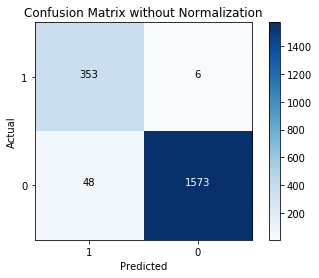

In [69]:
import itertools
plt.imshow(c_m,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(2) # length of classes
class_labels = ['1','0']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = c_m.max() / 2.
for i,j in itertools.product(range(c_m.shape[0]),range(c_m.shape[1])):
    plt.text(j,i,format(c_m[i,j],'d'),horizontalalignment='center',color='white' if c_m[i,j] >thresh else 'black')
plt.show();

#### Feature Importance

In [80]:
list(zip(X_train_oh.columns,best_model.feature_importances_))

[('Distance', 0.08542327402413599),
 ('ArrDelay', 0.8815841814822485),
 ('Month_Season_Fall', 0.006441846480878617),
 ('Month_Season_Spring', 0.0024690552653685066),
 ('Month_Season_Summer', 0.0024422735683183863),
 ('Month_Season_Winter', 0.006856988908345152),
 ('UniqueCarrier_AA', 0.004569994658369084),
 ('UniqueCarrier_DL', 0.007617391969314692),
 ('UniqueCarrier_UA', 0.0025949936430215226)]

## Q2 - Write your own function that uses the model output to predict whether a future ﬂight will be canceled.

In [197]:
def cancel_pred(Season,Carrier_airlines,Arrival_Delay,Dist):
    interm_df =  pd.DataFrame({'Month_Season':[Season],'Carrier':[Carrier_airlines],'ArrDelay':[Arrival_Delay],'Distance':[Dist]})
    X_test_oh = pd.get_dummies(interm_df)
    
    X_test_full = pd.DataFrame({'ArrDelay':[0], 'Distance':[0], 'Month_Season_Fall':[0], 'Month_Season_Spring':[0],
       'Month_Season_Summer':[0], 'Month_Season_Winter':[0], 'UniqueCarrier_AA':[0],
       'UniqueCarrier_DL':[0], 'UniqueCarrier_UA':[0]})
    
    for col in list(set(X_test_oh.columns) & set(X_test_full.columns)):
        X_test_full[col] = X_test_oh[col]
    
    
    y_pred = best_model.predict(X_test_full)
    
    if (y_pred==0):
        print('Flight might not get cancelled')
    else:
        print('Flight might get cancelled')

In [206]:
cancel_pred('Winter','AA',1000,4000)

Flight might not get cancelled


## Q4 - Provide a recommendation on which airline is most reliable.

C:\Users\archo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


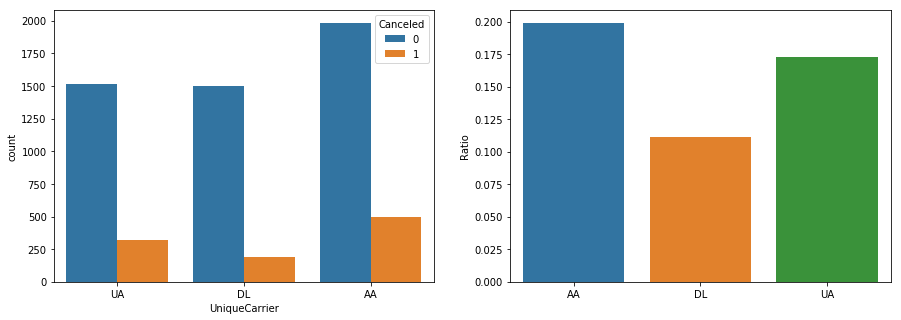

In [210]:
df_uc_new = df_new.groupby('UniqueCarrier').Canceled.agg({
    '0': lambda x: (x==0).sum(),
    '1': lambda x: (x==1).sum()
})

df_uc_new['Ratio'] = df_uc_new['1']/(df_uc_new['0']+df_uc_new['1'])
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax1 = sns.countplot(x="UniqueCarrier", hue="Canceled", data=df_new, ax = ax[0])
ax2 = sns.barplot(x=df_uc_new.index.values, y="Ratio", data=df_uc_new, ax = ax[1])

##### 'DL' airlines is most reliable. This is because the ratio of canceled/total is 0.1 which is the least among all the airlines

## SQL 

In [1]:
## Connecting to DB

import mysql.connector
import pandas as pd

conn = mysql.connector.connect(host="localhost", port=3306, user="root", passwd="pinkftw94@", db="digitas")

query1 = ('''
select t2.*
from 
(
Select  t1.Age, 
((count(t1.Age)/ (Select count(distinct Name_vals) from Demos where Age is not null and Name_vals  not in (select Visitor from fraud))) * 100) as 'Percentage'
from (SELECT Name_vals, max(Age) as Age
FROM Demos
Group by Name_vals) as t1
where t1.Age is not null
and t1.Name_vals  not in (select Visitor from fraud)
Group by t1.Age
) as t2
where t2.Percentage > 5
''')

query1 = query1.replace("\n"," ")

query_2 = ('''
Select Visitor, avg(Transactions) as AVG_Trans, IF(max(Transactions) > 100,'1','0') as 'Indicator'
from Purchases
where Visitor in (Select d.Name_vals
from Demos d
where d.Name_vals not in ( select Visitor from fraud)
and d.Age is not null
and d.Age = (Select max(Age) from Demos where Name_vals = d.Name_vals))
group by Visitor
Having Visitor like 'A%'
ORDER by AVG_Trans DESC
LIMIT 10;''')

query_2 = query_2.replace("\n"," ")


df_query_1 = pd.read_sql_query(query1, conn)

df_query_2 = pd.read_sql_query(query_2, conn)


In [2]:
df_query_1

,Age,Percentage
0,30,5.8824
1,26,5.8824
2,29,5.8824
3,25,5.8824
4,37,5.8824
5,40,5.8824
6,20,64.7059


In [3]:
df_query_2

,Visitor,AVG_Trans,Indicator
0,Aaron,310.0,1
1,Amber,120.0,1
2,Adol,120.0,1
3,Ashley,120.0,1
4,Aldona,120.0,1
5,Ann,120.0,1
6,Archit,60.0,1
7,Aster,20.0,0
8,Ash,20.0,0
9,Andy,20.0,0


In [2]:
!jupyter nbconvert Digitas1.ipynb --to html

[NbConvertApp] Converting notebook Digitas1.ipynb to html
[NbConvertApp] Writing 502778 bytes to Digitas1.html
